### Problem statement:
To understand if there is an issue with Waterco' customers paying a given invoice late, and what factors influence it

### Areas to cover:
What are the key findings from the dataset that are important and relevant to the clients problem?
How did you arrive at these findings?

### The approaches of the project are in the following steps:
1. Data cleaning and pre-processing
2. Statistical analysis and feature selection
3. Building supervised learning models with training data
4. Test and evaluate the performance of classification models

In [1]:
#Import required packages
import pandas as pd
from pandas import DataFrame
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.misc
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, precision_recall_fscore_support
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.utils import resample
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import scikitplot as skplt
%matplotlib inline

### Waterco invoice dataset:
Name: waterloo_missing_payment_data_LC.csv

#### Target and features:
* Target – Billing_Issues_1month: This is the primary column to predict, this indicates if the account has raised distress with the invoice provided
* Invoice_Count: Count of invoices sent to this account
* Qtr: Quarter the invoice was sent in 
* Year: Year the invoice was sent in 
* Billing_Method: Method used to communicate the invoice 
* Payment_Method: Method used to pay for the invoice 
* Risk_Factor: Predetermined risk factor of the account 
* Hardship_Notice: If the account is currently placed on hardship (unable to pay a bill, etc) 
* Payment_Agreement: If the account has an agreement for payment of previous outstanding invoices
* Concession_Agreement: If the account has any agreed concession for payment of invoices 
* High_Usage_Indicator: If the account has been determined to be a high-water user
* Invoice_Notice_Sent: Invoice sent to the account 
* Final_Notice_Sent: Final invoice reminder sent to the account
* Payment_Issue_Notice: Notice issue to the account if there are payment issues with reoccurring payment plans
* Requested_Additional_Payment_Time: If the account has requested additional time to pay a bill 
* Gov_Grant_Enrolled: If the are enrolled in the Welfare or Temporary Assistance for Needy Families (TANF) provided by the USA Government
* Prior_Hardship_Notice: If the account has been placed on hardship (unable to pay a bill, etc) previously
* Complaint_Count: Count of complaints made by the account to the service team
* Customer_Contact_Count: Count of the amount of contact between account and service team
* Property_Type: Type of property 
* Property_Suburb: Suburb of property location
* Property_County: County of property location
* Gov_Housing: If the are enrolled in the Welfare or Temporary Assistance for Needy Families (TANF) provided by the USA Government in Government housing 
* Qtr_Rain_MM: Measurement of rainwater for County quarterly 


#### Categorical features:
* Yes and No:
    * Billing_Issues_1month
    * Hardship_Notice
    * Payment_Agreement
    * Concession_Agreement
    * High_Usage_Indicator
    * Invoice_Notice_Sent
    * Final_Notice_Sent
    * Payment_Issue_Notice
    * Requested_Additional_Payment_Time
    * Gov_Grant_Enrolled
    * Prior_Hardship_Notice
    * Gov_Housing
* Others:
    * Billing_Method (Mail, Email, BPAY View)
    * Payment_Method (Payment_Method 1-20)
    * Risk_Factor (Low Risk, Excluded, Medium Risk, High Risk, Risk Not Calculated)
    * Property_Type (Dwelling, Apartment, Unit)
    * Property_Suburb (Property_Suburb 1-248)
    * Property_County (Property_County 1-15 & 17)

#### Numerical features:
* Invoice_Count (to be investigated for outliers)
* Qtr (binned: 1, 2, 3 where 3 has only about 1500 items)
* Complaint_Count (binned: 0, 1, 2, 3, 4 where 2 has 125, 3 has 29, and 4 has only 1 item)
* Customer_Contact_Count (to be investigated for outliers)
* Qtr_Rain_MM (binned: 24 values)

### Data Exploration & Cleaning

In [2]:
#Read both the data sets
pd.set_option('display.max_columns', None)
waterco_data = pd.read_csv("Data/waterco_missed_payments_data_LC.csv")
waterco_data.head()

,Billing_Issues_1month,Invoice_Count,Qtr,Year,Billing_Method,Payment_Method,Risk_Factor,Hardship_Notice,Payment_Agreement,Concession_Agreement,High_Usage_Indicator,Invoice_Notice_Sent,Final_Notice_Sent,Payment_Issue_Notice,Requested_Additional_Payment_Time,Gov_Grant_Enrolled,Prior_Hardship_Notice,Complaint_Count,Customer_Contact_Count,Property_Type,Property_Suburb,Property_County,Gov_Housing,Qtr_Rain_MM
0,No,50,1,2017,Mail,Payment_Method 1,Low Risk,No,Yes,No,No,Yes,Yes,Yes,Yes,No,No,NaN,8,Dwelling,Property_Suburb 1,Property_County 1,No,152.2
1,No,51,2,2017,Mail,Payment_Method 1,Low Risk,No,Yes,No,No,Yes,Yes,Yes,Yes,No,No,NaN,8,Dwelling,Property_Suburb 1,Property_County 1,No,172.1
2,No,38,1,2017,Mail,Payment_Method 2,Low Risk,No,No,No,No,Yes,Yes,No,No,No,No,NaN,1,Dwelling,Property_Suburb 3,Property_County 3,No,132.8
3,No,34,1,2017,Mail,Payment_Method 2,Low Risk,No,No,Yes,No,Yes,No,No,Yes,No,No,NaN,3,Unit,Property_Suburb 4,Property_County 1,No,152.2
4,Yes,33,1,2017,Email,Payment_Method 4,Low Risk,No,No,No,No,Yes,Yes,No,Yes,No,No,NaN,4,Unit,Property_Suburb 5,Property_County 4,No,98.2


In [3]:
waterco_data.shape

(313962, 24)

In [4]:
waterco_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313962 entries, 0 to 313961
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Billing_Issues_1month              313962 non-null  object 
 1   Invoice_Count                      313962 non-null  int64  
 2   Qtr                                313962 non-null  int64  
 3   Year                               313962 non-null  int64  
 4   Billing_Method                     313962 non-null  object 
 5   Payment_Method                     313962 non-null  object 
 6   Risk_Factor                        313962 non-null  object 
 7   Hardship_Notice                    313962 non-null  object 
 8   Payment_Agreement                  313962 non-null  object 
 9   Concession_Agreement               313962 non-null  object 
 10  High_Usage_Indicator               313962 non-null  object 
 11  Invoice_Notice_Sent                3139

Summary: The dataset has a lot of categorical columns. Complain_Count is the only colum with missing values.

#### Dropping constant features & duplicate rows

In [5]:
waterco_data = waterco_data.loc[:, waterco_data.nunique() != 1]

In [6]:
waterco_data = waterco_data.drop_duplicates()
waterco_data.shape

(288187, 23)

Summary: Since the value of Year is only 2017, this column is removed (constant feature). 
The non-null+null count is reduced to 288187 after removing row duplicates for all features.

### Feature Transformation

#### Missing values treatment:
Looking at the data, the only column with missing values is the 'Complaint_Count' column, 
the missing values represents 0.

In [7]:
# replace missing values with 0
waterco_data['Complaint_Count'].loc[waterco_data['Complaint_Count'].isna()] = 0
# converting the type from float to int
waterco_data['Complaint_Count'] = waterco_data['Complaint_Count'].astype(int)
#count values in Complaint_Count column
waterco_data['Complaint_Count'].value_counts()

0    286739
1      1302
2       116
3        29
4         1
Name: Complaint_Count, dtype: int64

#### Spreadibility and Cardinality analysis

Text(0.5, 1.0, 'Cardinality')

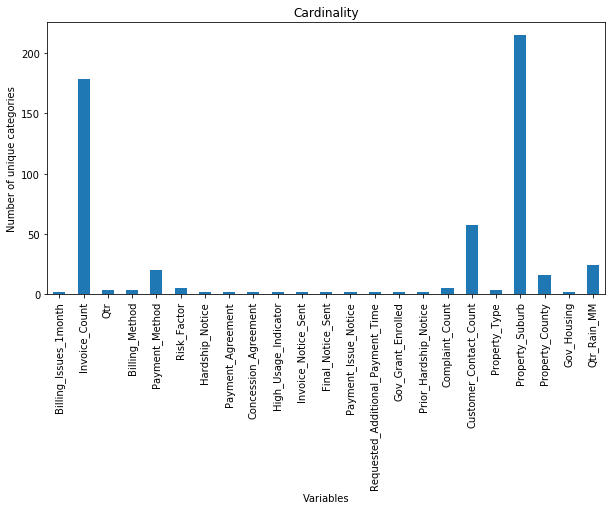

In [8]:
# waterco_data.nunique()
waterco_data.nunique().plot.bar(figsize=(10,5))
plt.ylabel('Number of unique categories')
plt.xlabel('Variables')
plt.title('Cardinality')

Summary: Invoice_Count, Payment_Method, Customer_Constact_Count, Propoert_Syburb, Property_County, and Qtr_Rain_MM
are categorical/discrete columns with variation/cardinality issue. More analysis would be needed to see if binning
would help.

#### categorical to numerical conversion:
Many of the categorical features only have Yes/No and so can be easily converted to 1/0 respectively.
Similarly, Billing_Method, Property_Type, and Risk_Factor have only 3 to 5 options that can be converted to 1-3, 1-5
respectively.
Payment_Method, Property_Suburb and Property_County are converted to numerical values by striping and removed the
'Payment' word from the start of the values. The resulting feature could have further binning to avoid sparsity issue.

In [9]:
#Yes/No items
waterco_data['Billing_Issues_1month'] = np.where(waterco_data['Billing_Issues_1month'] =='Yes',1,0)
waterco_data['Hardship_Notice'] = np.where(waterco_data['Hardship_Notice'] =='Yes',1,0)
waterco_data['Payment_Agreement'] = np.where(waterco_data['Payment_Agreement'] =='Yes',1,0)
waterco_data['Concession_Agreement'] = np.where(waterco_data['Concession_Agreement'] =='Yes',1,0)
waterco_data['High_Usage_Indicator'] = np.where(waterco_data['High_Usage_Indicator'] =='Yes',1,0)
waterco_data['Invoice_Notice_Sent'] = np.where(waterco_data['Invoice_Notice_Sent'] =='Yes',1,0)
waterco_data['Final_Notice_Sent'] = np.where(waterco_data['Final_Notice_Sent'] =='Yes',1,0)
waterco_data['Payment_Issue_Notice'] = np.where(waterco_data['Payment_Issue_Notice'] =='Yes',1,0)
waterco_data['Requested_Additional_Payment_Time'] = np.where(
    waterco_data['Requested_Additional_Payment_Time'] =='Yes',1,0)
waterco_data['Gov_Grant_Enrolled'] = np.where(waterco_data['Gov_Grant_Enrolled'] =='Yes',1,0)
waterco_data['Prior_Hardship_Notice'] = np.where(waterco_data['Prior_Hardship_Notice'] =='Yes',1,0)
waterco_data['Gov_Housing'] = np.where(waterco_data['Gov_Housing'] =='Yes',1,0)
# waterco_data['Gov_Housing'] = waterco_data['Gov_Housing'].astype('category').cat.codes

#Others
waterco_data['Payment_Method'] = waterco_data['Payment_Method'].str.split(' ').str[-1].astype('int')
waterco_data['Property_Suburb'] = waterco_data['Property_Suburb'].str.split(' ').str[-1].astype('int')
waterco_data['Property_County'] = waterco_data['Property_County'].str.split(' ').str[-1].astype('int')
waterco_data['Billing_Method'].replace(to_replace=['Mail', 'Email', 'BPAY View'], value=[1, 2, 3], inplace=True)
waterco_data['Property_Type'].replace(to_replace=['Dwelling', 'Apartment', 'Unit'], value=[1, 2, 3], inplace=True)
waterco_data['Risk_Factor'].replace(to_replace=['Low Risk', 'Excluded', 'Medium Risk', 'High Risk', 
                                                'Risk Not Calculated'], value=[1, 2, 3, 4, 5], inplace=True)
waterco_data.head(3)

,Billing_Issues_1month,Invoice_Count,Qtr,Billing_Method,Payment_Method,Risk_Factor,Hardship_Notice,Payment_Agreement,Concession_Agreement,High_Usage_Indicator,Invoice_Notice_Sent,Final_Notice_Sent,Payment_Issue_Notice,Requested_Additional_Payment_Time,Gov_Grant_Enrolled,Prior_Hardship_Notice,Complaint_Count,Customer_Contact_Count,Property_Type,Property_Suburb,Property_County,Gov_Housing,Qtr_Rain_MM
0,0,50,1,1,1,1,0,1,0,0,1,1,1,1,0,0,0,8,1,1,1,0,152.2
1,0,51,2,1,1,1,0,1,0,0,1,1,1,1,0,0,0,8,1,1,1,0,172.1
2,0,38,1,1,2,1,0,0,0,0,1,1,0,0,0,0,0,1,1,3,3,0,132.8


### Outliers treatment:

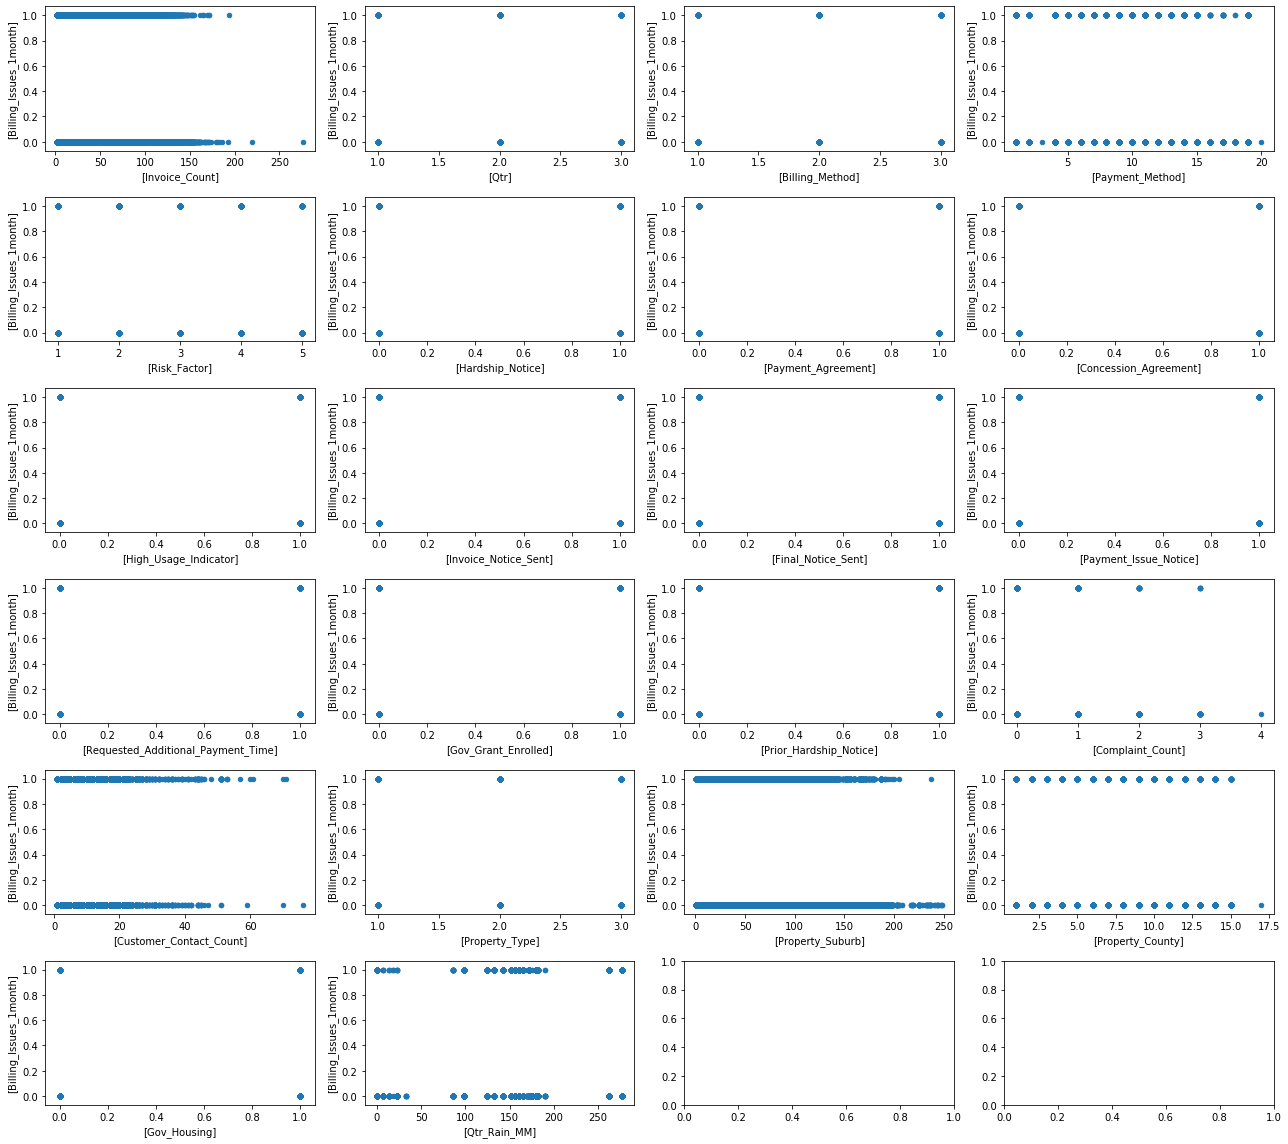

In [10]:
X_scatter = list(waterco_data.columns[1:])
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(18, 16))

axe = axes.ravel()
for i, col in enumerate(X_scatter):
    waterco_data.plot(x=[col], y=["Billing_Issues_1month"], kind="scatter", ax=axe[i])

plt.tight_layout()

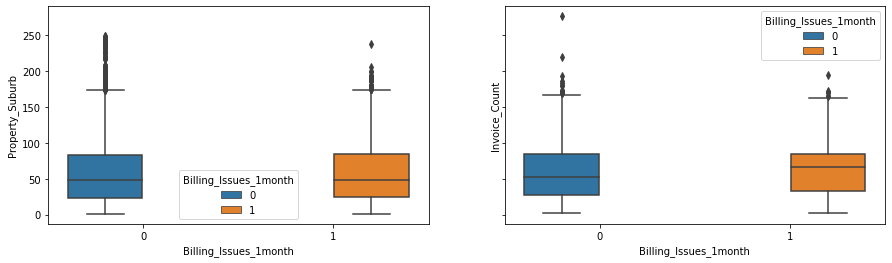

In [11]:
features = ['Property_Suburb', 'Invoice_Count']
fig, axes =plt.subplots(1,2, sharex='col', sharey='row', figsize=(15, 4))
for i,t in enumerate(features):
    sns.boxplot(y=t, x= "Billing_Issues_1month", data=waterco_data,  orient='v',ax=axes[i % 2] ,  
                hue='Billing_Issues_1month')

In [12]:
waterco_data.shape

(288187, 23)

In [13]:
waterco_data_ic = waterco_data.filter(['Invoice_Count'], axis=1)
sorted(waterco_data_ic)
Q1_ic = waterco_data_ic.quantile(0.25)
Q3_ic = waterco_data_ic.quantile(0.75)
IQR_ic = Q3_ic - Q1_ic
waterco_data_out_ic = waterco_data[~((waterco_data_ic < (Q1_ic - 1.5 * IQR_ic)) |(
    waterco_data_ic > (Q3_ic + 1.5 * IQR_ic))).any(axis=1)]
waterco_data_out_ic.shape
# Data size changes to (288166, 23) from (288187, 23) after the outliers removal for Invoice_Count

(288166, 23)

In [14]:
waterco_data_ps = waterco_data.filter(['Property_Suburb'], axis=1)
sorted(waterco_data_ps)
Q1_ps = waterco_data_ps.quantile(0.25)
Q3_ps = waterco_data_ps.quantile(0.75)
IQR_ps = Q3_ps - Q1_ps
waterco_data_out_icps = waterco_data_out_ic[~((waterco_data_ps < (Q1_ps - 1.5 * IQR_ps)) |(
    waterco_data_ps > (Q3_ps + 1.5 * IQR_ps))).any(axis=1)]
waterco_data_out_icps.shape
# Data size changes to (286829, 23) from (288187, 23) after the outliers removal for
# both Invoice_Count and Property_Suburb

/Users/atieh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


(286829, 23)

Summary: water_data_out_ic and waterco_data_out_icps will be used while training in addition to waterco_data
to check the model performance and if it improved by removing the outliers.

### Data Distribution:

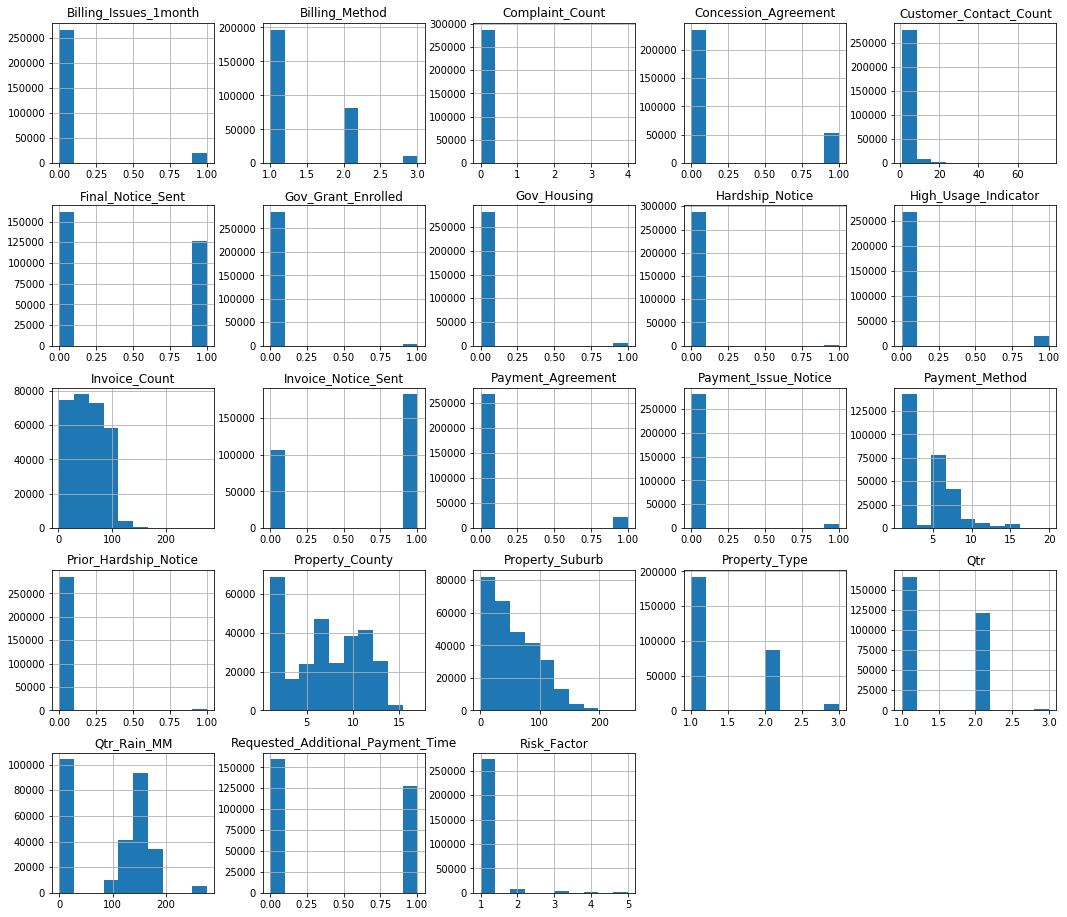

In [15]:
waterco_data.hist(figsize=(18, 16))
plt.show()

Summary: the target variable is an imbalanced data (intrinsic). This will be considered during the model training

### Feature Selection:

#### Feature selection: Correlation analysis

In [16]:
corr_matrix = waterco_data.corr()
print(corr_matrix["Billing_Issues_1month"].sort_values(ascending=False))

Billing_Issues_1month                1.000000
Customer_Contact_Count               0.304029
Gov_Housing                          0.297901
Payment_Method                       0.201749
High_Usage_Indicator                 0.142321
Risk_Factor                          0.104716
Requested_Additional_Payment_Time    0.096759
Invoice_Count                        0.045251
Property_Type                        0.028293
Hardship_Notice                      0.023838
Payment_Issue_Notice                 0.010770
Qtr_Rain_MM                          0.008076
Complaint_Count                      0.006988
Gov_Grant_Enrolled                   0.006675
Prior_Hardship_Notice                0.005456
Property_Suburb                      0.001560
Property_County                      0.001223
Payment_Agreement                   -0.001852
Qtr                                 -0.002177
Concession_Agreement                -0.015180
Final_Notice_Sent                   -0.045936
Billing_Method                    

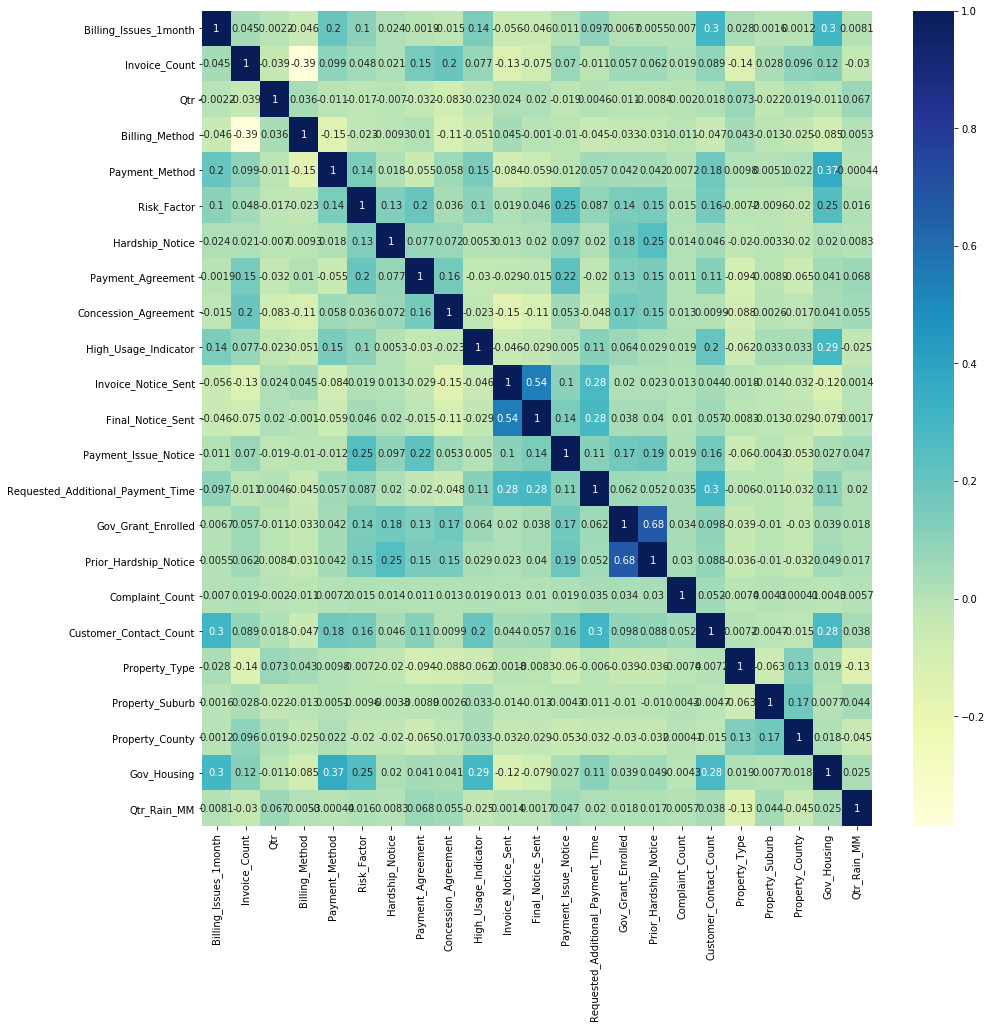

In [17]:
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.show()

Summary: Customer_Contact_Count, Gov_Housing, Payment_Method, High_Usage_Indicator, Risk_Factor, 
Requested_Additional_Payment_Time are ranked highest among the features.
Prior_Harship_notice and Gov_Grant_Enrolled have 68% correlation. One can be removed to check its impact on model
performance.

#### Feature selection: Filter Method - Univariate selection (chi-squared)
Statistical tests can be used to select those features that have the strongest relationship with the output variable.
The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests 
to select a specific number of features.
Here chi-squared (chi²) statistical test for non-negative features to select 10 of the best features.

In [18]:
# https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
X = waterco_data.drop("Billing_Issues_1month",1)   #Feature Matrix
y = waterco_data["Billing_Issues_1month"]          #Target Variable

In [19]:
#apply SelectKBest class to extract top 10 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(22,'Score')) 

                                Specs         Score
16             Customer_Contact_Count  86820.828675
3                      Payment_Method  25314.188047
20                        Gov_Housing  25003.398167
0                       Invoice_Count  10329.399320
8                High_Usage_Indicator   5430.468431
12  Requested_Additional_Payment_Time   1496.642769
21                        Qtr_Rain_MM   1142.723893
4                         Risk_Factor    516.354604
10                  Final_Notice_Sent    340.960880
9                 Invoice_Notice_Sent    329.171991
5                     Hardship_Notice    163.408809
2                      Billing_Method    136.416481
7                Concession_Agreement     54.141692
17                      Property_Type     50.361183
11               Payment_Issue_Notice     32.534334
18                    Property_Suburb     20.635574
15                    Complaint_Count     17.613236
13                 Gov_Grant_Enrolled     12.696160
14          

Summary: Customer_Contact_Count, Payment_Method, Gov_Housing, Invoice_Count, High_Usage_Indicator,
Requested_Additional_Payment_Time, Qtr_Rain_MM, and Risk_Factor are ranked highest among the features

#### Feature selection: Wrapper method
All the possible features are fed to the model at first. We check the performance of the model and then iteratively 
remove the worst performing features one by one till the overall performance of the model comes in acceptable range.
The performance metric used here to evaluate feature performance is pvalue. 
If the pvalue is above 0.05 then we remove the feature, else we keep it.

In [20]:
#Adding constant column of ones, mandatory for sm.OLS model (Backward Elimination)
X_be = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_be).fit()
model.pvalues.sort_values(ascending=False)

Property_Suburb                      3.953715e-01
Qtr_Rain_MM                          3.536784e-01
Invoice_Count                        2.843732e-01
Complaint_Count                      1.929171e-02
Qtr                                  3.389312e-04
const                                1.622293e-05
Property_County                      5.568820e-06
Billing_Method                       6.997036e-07
Gov_Grant_Enrolled                   4.225310e-07
Prior_Hardship_Notice                3.604056e-10
Requested_Additional_Payment_Time    4.410306e-13
Hardship_Notice                      2.919854e-23
Risk_Factor                          1.037219e-23
Payment_Issue_Notice                 4.546047e-26
Property_Type                        8.402102e-27
Invoice_Notice_Sent                  5.277283e-34
Payment_Agreement                    2.148521e-36
High_Usage_Indicator                 6.516631e-43
Final_Notice_Sent                    4.031041e-48
Concession_Agreement                 2.233399e-54


Summary: Property_Suburm, Qtr_Rain_MM and Invoice_Count have p-value above 0.05.

#### Feature selection: Embedded method
Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient 
threshold. Here Lasso regularization is used. If the feature is irrelevant, lasso penalizes it’s coefficient 
and make it 0. Hence the features with coefficient = 0 are removed and the rest are taken.

In [21]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.000362
Best score using built-in LassoCV: 0.153523


Text(0.5, 1.0, 'Feature importance using Lasso Model')

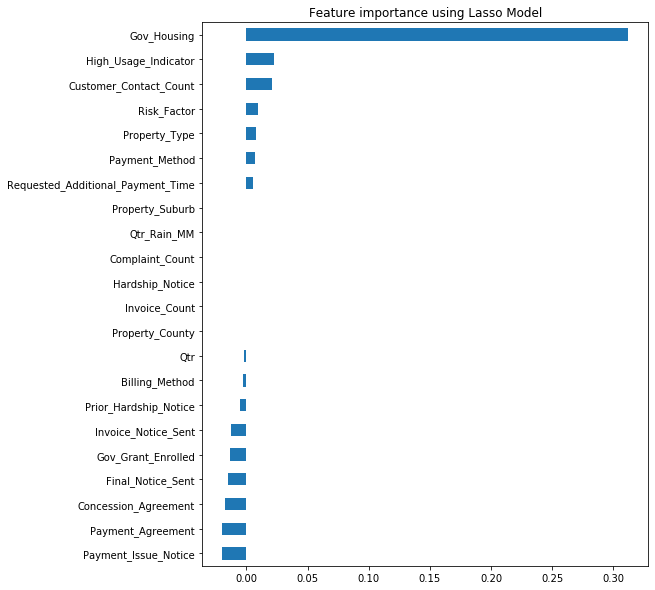

In [22]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
# print(coef != 0)

Summary: Hardship_notice, Complain_Count, Qtr_Rain_MM, Property_Suburb, Invoice_Count, and Property_County 
are shown as least important from this analysis.

Final SUmmary: in all the feature selection analysis, Gov_housing, Customer_Contact_count, Risk_factor, 
High_Usage_Indicator, Payment_Method are ranked among top 10. 
Following the Hybrid method other features will be added to test the model performance.

### Model training

#### Instrinsic Imballanced dataset:
extremely imballaed - approaches used to balance the data:
* Upsampling/downsampling
* weighted approach

In [23]:
waterco_data_out_icps['Billing_Issues_1month'].value_counts()

0    265804
1     21025
Name: Billing_Issues_1month, dtype: int64

In [25]:
# check the distribution
waterco_data_out_icps['Billing_Issues_1month'].value_counts()/waterco_data_out_icps.shape[0]

0    0.926698
1    0.073302
Name: Billing_Issues_1month, dtype: float64

### Logistic Regression

#### Logistic Regression (Default)

the originall data is compared with the one after outlier removal and the performance was similar. The dataset
with removed outliers is used in the training.

In [26]:
X_out = waterco_data_out_icps.drop("Billing_Issues_1month",1)   #Feature Matrix after outlier removal
y_out = waterco_data_out_icps["Billing_Issues_1month"]          #Target Variable

In [27]:
# train-test split
X_selected = X_out.drop(["Qtr_Rain_MM", "Property_County", "Property_Suburb", "Qtr", "Hardship_Notice", 
                        "Complaint_Count", "Invoice_Count", "Billing_Method", "Prior_Hardship_Notice", 
                        "Property_Type", "Invoice_Notice_Sent", "Gov_Grant_Enrolled", "Final_Notice_Sent", 
                        "Concession_Agreement", "Payment_Agreement", "Payment_Issue_Notice",
                        "Requested_Additional_Payment_Time", "Payment_Method", "Property_Type", "Risk_Factor"],1)
X_selected_o = X_selected
X_train, X_test, y_train, y_test = train_test_split(X_selected_o, y_out, test_size=0.2,random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Features were dropped one by one and the model performance was tested for each case.

In [28]:
# define model
lg = LogisticRegression(random_state=13, class_weight=None)
# fit it
lg.fit(X_train_scaled,y_train)
# test
y_pred = lg.predict(X_test_scaled)
y_score = lg.predict_proba(X_test_scaled)

Logit_test = metrics.average_precision_score(y_test, y_pred)
print("Logistic test score:",Logit_test)

# performance
conf_mat = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
score = precision_recall_fscore_support(y_test, y_pred, average='weighted')
precision, recall, fscore, k = score
print(classification_report(y_test, y_pred))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)
print(f'Area Under Curve: {roc_auc_score(y_test,y_pred)}')

Logistic test score: 0.2051236549970316
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     53261
           1       0.80      0.18      0.30      4105

    accuracy                           0.94     57366
   macro avg       0.87      0.59      0.63     57366
weighted avg       0.93      0.94      0.92     57366

Accuracy: 0.9382735418191961
Precision: 0.9304556536544827
Recall: 0.9382735418191961
F score: 0.9198406278918693
Area Under Curve: 0.5900555513616317


Sumarry: the influence of the imbanace data is visible here. The model predicts the majority class very well but has 
problem predicting the minarity class. Downsampling below is used to remove data bias and to balance the date.

#### Downsampling:
The target variable is resampled by downsampling the majority class (Billing_Issues_1month=0) to be equal to the
minarity class (1)

In [29]:
data_majority = waterco_data_out_icps[waterco_data_out_icps.Billing_Issues_1month==0]
data_minority = waterco_data_out_icps[waterco_data_out_icps.Billing_Issues_1month==1]

data_minarity_downsampled = resample(data_majority, replace=True, n_samples=21025, random_state=123)

Logistic test score: 0.625142886236967
              precision    recall  f1-score   support

           0       0.63      0.83      0.71      4211
           1       0.75      0.51      0.61      4199

    accuracy                           0.67      8410
   macro avg       0.69      0.67      0.66      8410
weighted avg       0.69      0.67      0.66      8410

Accuracy: 0.66884661117717
Precision: 0.6870647478837454
Recall: 0.66884661117717
F score: 0.6604417411984927
Area Under Curve: 0.668622489245978


/Users/atieh/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


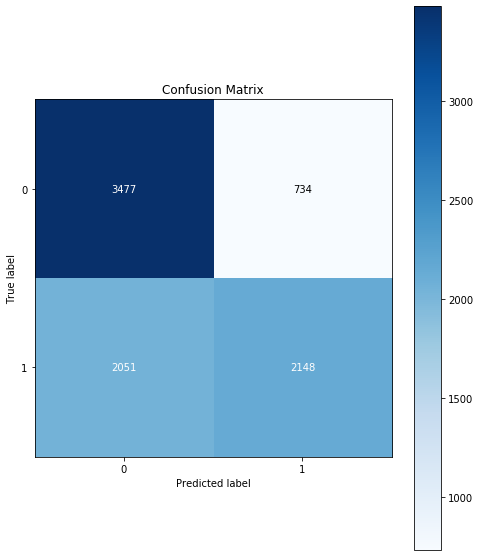

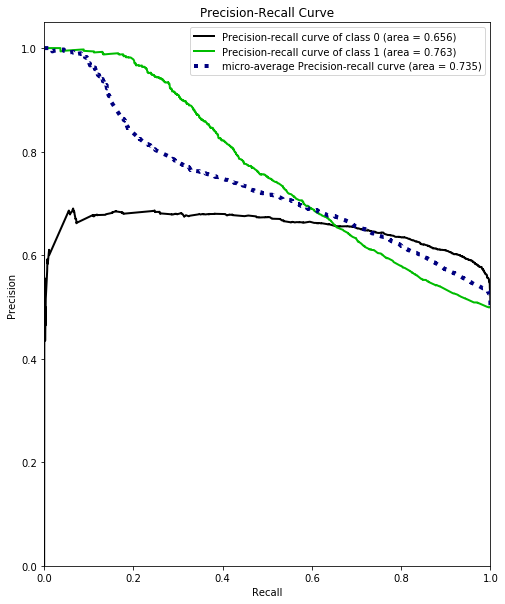

In [31]:
data_downsampled = pd.concat([data_minarity_downsampled, data_minority])
X_sampled = data_downsampled.drop("Billing_Issues_1month",1)
y_sampled = data_downsampled["Billing_Issues_1month"]

X_selected = X_sampled.drop(["Qtr_Rain_MM", "Property_County", "Property_Suburb", "Qtr", "Hardship_Notice", 
                        "Complaint_Count", "Invoice_Count", "Billing_Method", "Prior_Hardship_Notice",
                            "Property_Type", "Invoice_Notice_Sent"],1)
X_selected_sampled = X_selected

X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(
    X_selected_sampled, y_sampled, test_size=0.2, random_state=0)

scaler = StandardScaler().fit(X_train_sampled)
X_train_sam_scaled = scaler.transform(X_train_sampled)
X_test_sam_scaled = scaler.transform(X_test_sampled)

lg1 = LogisticRegression()
lg1.fit(X_train_sam_scaled, y_train_sampled)
y_pred_sampled = lg1.predict(X_test_sam_scaled)
y_score_sampled = lg1.predict_proba(X_test_sam_scaled)

Logit_test = metrics.average_precision_score(y_test_sampled, y_pred_sampled)
print("Logistic test score:",Logit_test)
# performance
conf_mat = confusion_matrix(y_test_sampled, y_pred_sampled)
accuracy = accuracy_score(y_test_sampled, y_pred_sampled)
score = precision_recall_fscore_support(y_test_sampled, y_pred_sampled, average='weighted')
precision, recall, fscore, k = score
skplt.metrics.plot_confusion_matrix(y_test_sampled, y_pred_sampled)
skplt.metrics.plot_precision_recall_curve(y_test_sampled, y_score_sampled)
print(classification_report(y_test_sampled, y_pred_sampled))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)
print(f'Area Under Curve: {roc_auc_score(y_test_sampled,y_pred_sampled)}')

#### Weighted Logistic Regression:
Adding penalty and weight to the modeling is another way of solving imbalance data problem specially when the number
of items in one class is much higher than the other one. I tried using this on the original data but the model
performance was bad. I also tried to use more complex wighting methods like XGBoost but the runtime was taking long 
and thus I did not focus further on this approach. 
for simplicity, I have added the approach on the balanced data from resampling step. The model performance did not change.

In [32]:
param_grid = [{'C': [10,11,12,13,14,20],'penalty': ['l1', 'l2']}]

model = LogisticRegression()

model2 = GridSearchCV(model, param_grid,cv=5, n_jobs=-1,scoring='roc_auc', refit=True)
model2.fit(X_train_sam_scaled,y_train_sampled)
print(model2.best_params_)
print(model2.best_score_)

{'C': 20, 'penalty': 'l2'}
0.7257654282760052


/Users/atieh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.72576449        nan 0.72576449        nan 0.72576449
        nan 0.72576449        nan 0.72576444        nan 0.72576543]
  category=UserWarning


In [33]:
# define model
# in the case of original data I used a class_weight of {0: 7, 1:93}
lg3 = LogisticRegression(random_state=13,C=20.0,fit_intercept=True, penalty='l2', class_weight = 'balanced')
# fit it
lg3.fit(X_train_sam_scaled,y_train_sampled)
# test
y_pred_sampled = lg3.predict(X_test_sam_scaled)

y_score_sampled = lg3.predict_proba(X_test_sam_scaled)

Logit_test = metrics.average_precision_score(y_test_sampled, y_pred_sampled)
print("Logistic test score:",Logit_test)
# performance
conf_mat = confusion_matrix(y_test_sampled, y_pred_sampled)
accuracy = accuracy_score(y_test_sampled, y_pred_sampled)
score = precision_recall_fscore_support(y_test_sampled, y_pred_sampled, average='weighted')
precision, recall, fscore, k = score
print(classification_report(y_test_sampled, y_pred_sampled))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)
print(f'Area Under Curve: {roc_auc_score(y_test_sampled,y_pred_sampled)}')

Logistic test score: 0.625142886236967
              precision    recall  f1-score   support

           0       0.63      0.83      0.71      4211
           1       0.75      0.51      0.61      4199

    accuracy                           0.67      8410
   macro avg       0.69      0.67      0.66      8410
weighted avg       0.69      0.67      0.66      8410

Accuracy: 0.66884661117717
Precision: 0.6870647478837454
Recall: 0.66884661117717
F score: 0.6604417411984927
Area Under Curve: 0.668622489245978


#### SMOTE:
This is another resampling method. I tried different sampling_strategy values but the performance did not improve.

In [34]:
# Separate input features and target
y_s = y_out
X_s = X_out

X_selected = X_out.drop(["Qtr_Rain_MM", "Property_County", "Property_Suburb", "Qtr", "Hardship_Notice", 
                        "Complaint_Count", "Invoice_Count", "Billing_Method", "Prior_Hardship_Notice", 
                        "Property_Type", "Invoice_Notice_Sent", "Gov_Grant_Enrolled", "Final_Notice_Sent", 
                        "Concession_Agreement", "Payment_Agreement", "Payment_Issue_Notice",
                        "Requested_Additional_Payment_Time", "Payment_Method", "Property_Type", "Risk_Factor"],1)
X_selected_smote = X_selected

# setting up testing and training sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_selected_smote, y_s, test_size=0.2, random_state=123)

sm = SMOTE(random_state=27, sampling_strategy=0.2)
X_train_smote, y_train_smote = sm.fit_sample(X_train_smote, y_train_smote)


In [35]:
smote = LogisticRegression().fit(X_train_smote, y_train_smote)

y_pred_smote = smote.predict(X_test_smote)

y_score_smote = smote.predict_proba(X_test_smote)

Logit_test = metrics.average_precision_score(y_test_smote, y_pred_smote)
print("Logistic test score:",Logit_test)
# performance
conf_mat = confusion_matrix(y_test_smote, y_pred_smote)
accuracy = accuracy_score(y_test_smote, y_pred_smote)
score = precision_recall_fscore_support(y_test_smote, y_pred_smote, average='weighted')
precision, recall, fscore, k = score
print(classification_report(y_test_smote, y_pred_smote))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)
print(f'Area Under Curve: {roc_auc_score(y_test_smote, y_pred_smote)}')

Logistic test score: 0.18270458778083531
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     53190
           1       0.55      0.23      0.33      4176

    accuracy                           0.93     57366
   macro avg       0.75      0.61      0.64     57366
weighted avg       0.91      0.93      0.92     57366

Accuracy: 0.9301502632221176
Precision: 0.9135630592460389
Recall: 0.9301502632221176
F score: 0.9167350058757862
Area Under Curve: 0.6081689097639561


In [ ]:
#took very long to run and so I did not proceed with it

# params = {'n_estimators':[250,500,750],'learning_rate':[0.001,0.01,0.1],'max_depth':[1,2,3,4,5,6]}

# xgb2 = XGBClassifier(random_state=42)
# lg4 = GridSearchCV(xgb2,params,cv=3,scoring='recall')
# lg4.fit(X_train, y_train)

# print(lg4.best_params_)
# print(lg4.best_score_)

In [ ]:
# clf = XGBClassifier(n_estimators=250,learning_rate=0.001,max_depth=2,random_state=42)
# clf.fit(X_train, y_train)

# y_score = clf.predict_proba(X_test)
# y_pred = clf.fit(X_train, y_train).predict(X_test)
# xgb_test = metrics.average_precision_score(Y_test, y_pred)
# print("XGB test score:",xgb_test)

In [ ]:
# conf_mat = confusion_matrix(y_test, y_pred)
# accuracy = accuracy_score(y_test, y_pred)
# score = precision_recall_fscore_support(y_test, y_pred, average='weighted')
# precision, recall, fscore, k = score
# skplt.metrics.plot_confusion_matrix(y_test, y_pred)
# skplt.metrics.plot_precision_recall_curve(y_test, y_score)
# print(classification_report(y_test, y_pred))
# print("Accuracy:",accuracy)
# print("Precision:",precision)
# print("Recall:",recall)
# print("F score:",fscore)

Final Sumarry: The f1_score and Accuracy of the Logist Regression form resampling is about ~66% which is not a very good number
But at the same time, the features correlation with target was low and thus further feature engineering approaches should 
be investigated.
Similarly, other resampling/ensample/impabance data correction approaches should be investigated as by using the current downsampling approach,
many data is removed which is not a preferable approach. I did not try the upsampling due to the extreme margin between
the two class.

#### Decision Tree

In [36]:
dt = DecisionTreeClassifier(criterion='gini')
dt.fit(X_train_sam_scaled, y_train_sampled)
y_score_sampled = dt.predict_proba(X_test_sampled)
y_pred_sampled = dt.predict(X_test_sampled)
# performance
conf_mat = confusion_matrix(y_test_sampled, y_pred_sampled)
accuracy = accuracy_score(y_test_sampled, y_pred_sampled)
score = precision_recall_fscore_support(y_test_sampled, y_pred_sampled, average='weighted')
precision, recall, fscore, k = score
print(classification_report(y_test_sampled, y_pred_sampled))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)
print(f'Area Under Curve: {roc_auc_score(y_test_sampled,y_pred_sampled)}')

              precision    recall  f1-score   support

           0       0.69      0.20      0.31      4211
           1       0.53      0.91      0.67      4199

    accuracy                           0.55      8410
   macro avg       0.61      0.55      0.49      8410
weighted avg       0.61      0.55      0.49      8410

Accuracy: 0.5539833531510107
Precision: 0.6111716639161945
Recall: 0.5539833531510107
F score: 0.48894229882832724
Area Under Curve: 0.5544926252357696


#### Other methods

Other methods such as SVM, KNN, Random Forest, and Neural Network could be used to compare the performance.